In [1]:
import fiona
import geopandas as gpd
import movingpandas as mpd
import folium
import contextily as cx

Os arquivos GPX não como XML (isso escutei falar)...
De qualquer forma, cada um deles armazena mais de uma "camada" espacial. Não necessáriamente todas possuem arquivos.
Pois com GPS se pode marcar [waypoint](https://pt.wikipedia.org/wiki/Waypoint), tracks e etc. Então todo GPX apresentará essas camadas, mesmo que as mesmas estejam sem dados. 

A camada com dados vai depender do que estão compartilhando conosco.

Eu já imaginei que seus dados de treino e os dados de prova estariam no formato de "track". vamos usar o [fiona](https://pypi.org/project/Fiona/) para listar as camadas que existem no gpx:

In [2]:
fiona.listlayers("../gpx-files/activity_10815706486.gpx")

['waypoints', 'routes', 'tracks', 'route_points', 'track_points']

Em geral a camada de `track` não é tão interessante, para a gente, por consolidar todo o caminho em um único registro. Daí teríamos que buscar uma forma de "quebrar" essa linha em segmentos para poder entender como o caminho se desenvolve. Além disso, não possui a informação de elevação (`ele`).

O bom é que esse mesmo `track` é, também, armazenado em formato de ponto, o `track_points`. E o melhor, cada ponto é um registro na camada, com uma coluna indicando a ordem de criação de cada um deles.
Vamos ver a diferença (veja que no parâmetro `layer`, definimos acamda a ser aberta...):

In [3]:
gpx_track = fiona.open("../gpx-files/activity_10815706486.gpx", layer='tracks')

track_gdf = gpd.GeoDataFrame.from_features(
    [feature for feature in gpx_track], crs=gpx_track.crs
)
track_gdf

,geometry,name,type
0,"MULTILINESTRING ((-75.70176 45.42190, -75.7016...",Ottawa Running,running


In [4]:
gpx_tpoints = fiona.open("../gpx-files/activity_10815706486.gpx", layer='track_points')

track_gdf = gpd.GeoDataFrame.from_features(
    [feature for feature in gpx_tpoints], crs=gpx_tpoints.crs
)
track_gdf

,geometry,track_fid,track_seg_id,track_seg_point_id,ele,time,ns3_TrackPointExtension
0,POINT (-75.70176 45.42190),0,0,0,75.400002,2023-04-01T19:57:41+00:00,<ns3:atemp>19.0</ns3:atemp> ...
1,POINT (-75.70162 45.42191),0,0,1,75.400002,2023-04-01T19:57:46+00:00,<ns3:atemp>19.0</ns3:atemp> ...
2,POINT (-75.70145 45.42196),0,0,2,75.599998,2023-04-01T19:57:50+00:00,<ns3:atemp>19.0</ns3:atemp> ...
3,POINT (-75.70141 45.42197),0,0,3,76.000000,2023-04-01T19:57:51+00:00,<ns3:atemp>19.0</ns3:atemp> ...
4,POINT (-75.70133 45.42201),0,0,4,76.199997,2023-04-01T19:57:53+00:00,<ns3:atemp>19.0</ns3:atemp> ...
...,...,...,...,...,...,...,...
1831,POINT (-75.70155 45.42198),0,0,1831,61.000000,2023-04-01T22:02:54+00:00,<ns3:atemp>12.0</ns3:atemp> ...
1832,POINT (-75.70159 45.42197),0,0,1832,60.799999,2023-04-01T22:02:55+00:00,<ns3:atemp>12.0</ns3:atemp> ...
1833,POINT (-75.70169 45.42192),0,0,1833,60.599998,2023-04-01T22:02:58+00:00,<ns3:atemp>12.0</ns3:atemp> ...
1834,POINT (-75.70173 45.42189),0,0,1834,75.400002,2023-04-01T22:02:59+00:00,<ns3:atemp>12.0</ns3:atemp> ...


Repare que com essa camada de pontos temos muito mais detalhes com informações a cada segmento percorrido....

Podemos fazer um webmap usando o [`folium`](https://python-visualization.github.io/folium/) com os pontos da atividade e uma camada base do OpenStreetMap

In [5]:
map = folium.Map(location=[
    track_gdf.iloc[0].geometry.y, 
    track_gdf.iloc[0].geometry.x], tiles="OpenStreetMap", zoom_start=12)
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in track_gdf.geometry]
for coordinates in geo_df_list:
    map.add_child(
        folium.Marker(
            location=coordinates))
    
map

O bacana seria transformar os pontos gerados na atividade em uma trajetória, usando o [movingpandas](https://movingpandas.org/index) e, com ele, teremos cada segmento da atividade como um registro diferente e a partir do qual pdoeremos calcular algumas coisas, como aceleração, distância, velocidade, etc, etc. [veja mais aqui](https://movingpandas.readthedocs.io/en/main/trajectory.html)

Pensando bem... a maioria desses atributos que podemos calcular com o movingpandas estão intitmamente relacionado com o tempo necessário para percorrer cada segmento. Ou seja, Dizem mais respeito ao rendimento do  atleta que da prova.

Acho que seria o caso de pensarmos em estatísticas que resumam a prova ou a atividade, e não o desempenho para poder comparar-las...
Mas depois volto a isso..

Transofmrando o GeoDataFrame a um Trajectory:

In [6]:
# convertendo em trajectory
trajectory = mpd.Trajectory(
    df=track_gdf, 
    traj_id="track_seg_point_id", 
    t="time"
)
trajectory

/home/felipe/.cache/pypoetry/virtualenvs/triatlhon-7JAv3fCL-py3.11/lib/python3.11/site-packages/movingpandas/trajectory.py:136: TimeZoneWarning: Time zone information dropped from trajectory. All dates and times will use local time. To use UTC or a different time zone, convert and drop time zone information prior to trajectory creation.
  warnings.warn(


Trajectory track_seg_point_id (2023-04-01 19:57:41 to 2023-04-01 22:03:00) | Size: 1836 | Length: 24005.8m
Bounds: (-75.70208234712481, 45.355216674506664, -75.6782850343734, 45.42510062456131)
LINESTRING (-75.70175821892917 45.42189815081656, -75.70161807350814 45.4219117294997, -75.701448256

Ele avisa que a informação de timezone foi removida e que será usada localtime. não vou me preocupar com isso agora...

In [7]:
#Calculando alguns atributos da atividade (de novo, a maioria dioz rewspeito ao rendimento do atleta...)
trajectory.add_acceleration(overwrite=True)
trajectory.add_distance(overwrite=True)  # in meters
trajectory.add_speed(overwrite=True)  # in meters per second
trajectory.add_timedelta(overwrite=True)
trajectory.df.timedelta = trajectory.df.timedelta.dt.total_seconds()


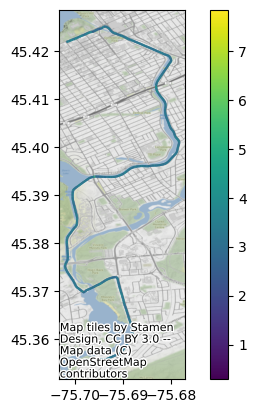

In [8]:
ax = trajectory.plot('speed', legend=True)
cx.add_basemap(ax, crs=trajectory.crs.to_string())

Acho que os segmentos são muito pequenos para poder notar a diferença nos dados... vou convertê-lo a geodataframe para pode acessar os atributos calculados e confirmar que os valores estão lá:

In [9]:
traj_gdf = trajectory.to_line_gdf()
traj_gdf.crs = trajectory.crs
traj_gdf.head()

,track_fid,track_seg_id,track_seg_point_id,ele,ns3_TrackPointExtension,acceleration,distance,speed,timedelta,t,prev_t,geometry
0,0,0,1,75.400002,<ns3:atemp>19.0</ns3:atemp> ...,0.000000,11.071959,2.214392,5.0,2023-04-01 19:57:46,2023-04-01 19:57:41,"LINESTRING (-75.70176 45.42190, -75.70162 45.4..."
1,0,0,2,75.599998,<ns3:atemp>19.0</ns3:atemp> ...,0.339208,14.284889,3.571222,4.0,2023-04-01 19:57:50,2023-04-01 19:57:46,"LINESTRING (-75.70162 45.42191, -75.70145 45.4..."
2,0,0,3,76.000000,<ns3:atemp>19.0</ns3:atemp> ...,-0.151611,3.419611,3.419611,1.0,2023-04-01 19:57:51,2023-04-01 19:57:50,"LINESTRING (-75.70145 45.42196, -75.70141 45.4..."
3,0,0,4,76.199997,<ns3:atemp>19.0</ns3:atemp> ...,0.149165,7.435881,3.717940,2.0,2023-04-01 19:57:53,2023-04-01 19:57:51,"LINESTRING (-75.70141 45.42197, -75.70133 45.4..."
4,0,0,5,76.400002,<ns3:atemp>19.0</ns3:atemp> ...,0.017246,7.504864,3.752432,2.0,2023-04-01 19:57:55,2023-04-01 19:57:53,"LINESTRING (-75.70133 45.42201, -75.70125 45.4..."


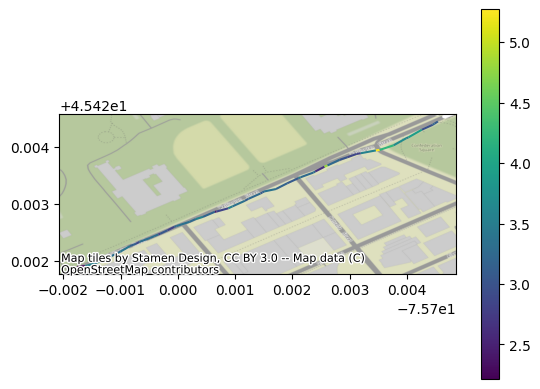

In [10]:
ax = traj_gdf.iloc[0:50].plot('speed', legend=True)
cx.add_basemap(ax, crs=trajectory.crs.to_string())

Ao usar o `folium` não consegui usar cor para representar os valores de algumatributo calculado...

In [11]:
map = folium.Map(location=[
    track_gdf.iloc[0].geometry.y, 
    track_gdf.iloc[0].geometry.x], tiles="OpenStreetMap", zoom_start=12)
points = [[point.xy[1][0], point.xy[0][0]] for point in traj_gdf.geometry]

folium.PolyLine(points).add_to(map)
map

Um ponto importante para se ter em consideração é o fato de os `tracks` poderem sere gerados de duas formas distintas:
    A cada X metros **ou** a cada X segundos. Ou seja por distância percorrida ou por tempo.

    

Analisando o `timedelta` e `distance` calculados fico sem saber como o seu GPS está configurado, pois vejo variação em ambos atributos.

<Axes: >

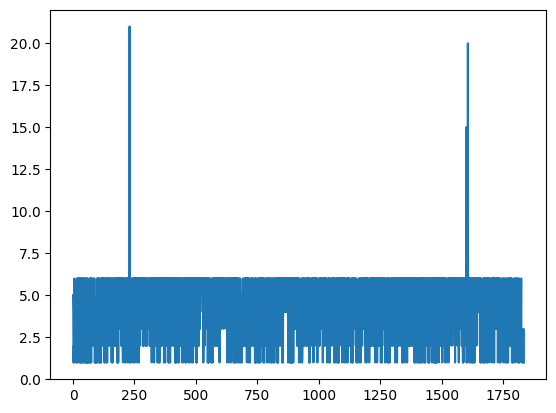

In [12]:
traj_gdf.timedelta.plot()

In [13]:
traj_gdf.timedelta.describe

<bound method NDFrame.describe of 0       5.0
1       4.0
2       1.0
3       2.0
4       2.0
       ... 
1830    1.0
1831    1.0
1832    3.0
1833    1.0
1834    1.0
Name: timedelta, Length: 1835, dtype: float64>

<Axes: >

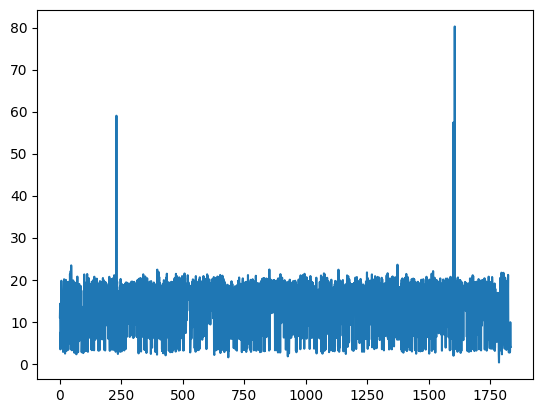

In [14]:
traj_gdf["distance"].plot()

In [15]:
traj_gdf["distance"].describe

<bound method NDFrame.describe of 0       11.071959
1       14.284889
2        3.419611
3        7.435881
4        7.504864
          ...    
1830     2.669940
1831     2.926526
1832     9.874618
1833     4.323193
1834     4.003104
Name: distance, Length: 1835, dtype: float64>